In [1]:
import pandas as pd
df = pd.read_csv("../Data/PV_data_clean.csv")

C:\Users\loolz\AppData\Local\Temp\ipykernel_19152\2824673452.py:2: DtypeWarning: Columns (8,9,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../Data/PV_data_clean.csv")


In [2]:
df.head(3)

,randid,Date,NOAAClimRegion,TempZone,HumidZone,bin_PlantSize_kW,plant_age_months,active_snow_tickets,snow_bin_ticket_minutes,snow_affected_assets,...,storm_production_level,lightning,storm,duration_minutes_storm,nearest_storm,flood,duration_minutes_flood,nearest_flood,rain,weather_onset
0,C2S1,2018-08-01,West,T6,H4,large,23.0,No,NaN,NaN,...,Unknown,0,0.0,0,2420,0.0,0,2255,0.0,0
1,C2S1,2018-08-02,West,T6,H4,large,23.0,No,NaN,NaN,...,Unknown,0,0.0,0,2420,0.0,0,2255,0.0,0
2,C2S1,2018-08-03,West,T6,H4,large,23.0,No,NaN,NaN,...,Unknown,0,0.0,0,2420,0.0,0,2255,0.0,0


In [3]:
df = df.drop(columns="PR")

In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

def map_string_to_num_features(df,pca_feature_cols):

    mapping_affected_assets = {"None": 0, "Partial": 1, "Full": 2}
    mapping_production_level = {"N/A": 0, "Unknown": 0, "Partial": 1, "Full": 2}
    mapping_wind_speed = {"Low": 0, "Medium": 1, "High": 2}

    if "snow_affected_assets" in pca_feature_cols:
        df["snow_affected_assets"] = df["snow_affected_assets"].map(mapping_affected_assets)
    if "snow_production_level" in pca_feature_cols:
        df["snow_production_level"] = df["snow_production_level"].map(mapping_production_level)
    if "hurr_affected_assets" in pca_feature_cols:
        df["hurr_affected_assets"] = df["hurr_affected_assets"].map(mapping_affected_assets)
    if "hurr_production_level" in pca_feature_cols:
        df["hurr_production_level"] = df["hurr_production_level"].map(mapping_production_level)
    if "wind_speed_mean" in pca_feature_cols:
        df["wind_speed_mean"] = df["wind_speed_mean"].map(mapping_wind_speed)
    if "storm_affected_assets" in pca_feature_cols:
        df["storm_affected_assets"] = df["storm_affected_assets"].map(mapping_affected_assets)
    if "storm_production_level" in pca_feature_cols:
        df["storm_production_level"] = df["storm_production_level"].map(mapping_production_level)

    return df


Top 3 original features contributing most to PC1:
rain_value_mm    0.377104
rain             0.373250
nearest_rain     0.338614
Name: PC1, dtype: float64

Top 3 original features contributing most to PC2:
total_daily_snow_mm      0.432708
snow_value_mm            0.431911
snow_production_level    0.349761
Name: PC2, dtype: float64

Top 3 original features contributing most to PC3:
lightning                 0.429704
storm_production_level    0.418548
low_irradiation           0.333407
Name: PC3, dtype: float64


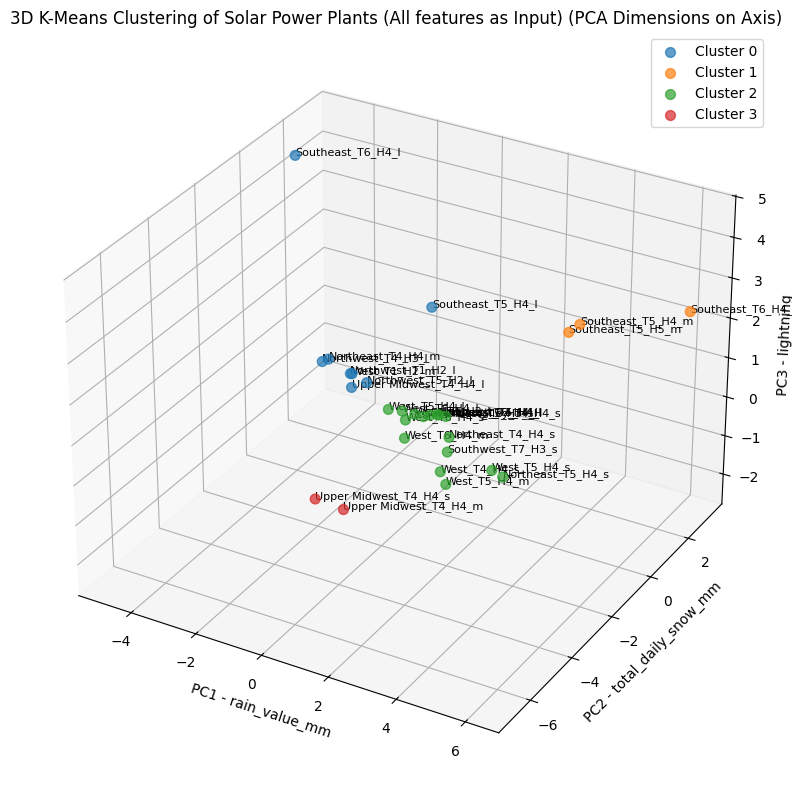

In [5]:
df["solar_power_plant"] = df["NOAAClimRegion"] + "_" + df["TempZone"] + "_" + df["HumidZone"] + "_" + df["bin_PlantSize_kW"].apply(lambda x: x[0])
pca_features_start_col = "active_snow_tickets"
pca_features_end_col = "rain"
pca_feature_cols = df.columns[df.columns.get_loc(pca_features_start_col):df.columns.get_loc(pca_features_end_col)+1].tolist()

df = map_string_to_num_features(df,pca_feature_cols)

# Filter pca_feature_cols to ensure only numerical columns are selected for aggregation
# This prevents applying mean() to non-numeric (object) columns.
numeric_pca_feature_cols = df[pca_feature_cols].select_dtypes(include=np.number).columns.tolist()

df_grouped = df.groupby("solar_power_plant")[numeric_pca_feature_cols].mean().reset_index()

X = df_grouped[numeric_pca_feature_cols].values

X = np.nan_to_num(X, nan=0.0)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

covariance_matrix = np.cov(X_scaled.T)

eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)

sorted_indices = np.argsort(eigenvalues)[::-1]
sorted_eigenvalues = eigenvalues[sorted_indices]
sorted_eigenvectors = eigenvectors[:, sorted_indices]

n_components = 3
principal_components = sorted_eigenvectors[:, :n_components]

X_pca = X_scaled.dot(principal_components)

# Use numeric_pca_feature_cols for feature_loadings index
feature_loadings = pd.DataFrame(principal_components, index=numeric_pca_feature_cols,
                                columns=[f"PC{i+1}" for i in range(n_components)])

########################################################

top_features_pc1 = feature_loadings["PC1"].abs().nlargest(3)

print(f"Top 3 original features contributing most to PC1:")
print(top_features_pc1)

# Get the top contributing feature for PC2
top_features_pc2 = feature_loadings["PC2"].abs().nlargest(3)
print(f"\nTop 3 original features contributing most to PC2:")
print(top_features_pc2)

# Get the top contributing feature for PC3
top_features_pc3 = feature_loadings["PC3"].abs().nlargest(3)
print(f"\nTop 3 original features contributing most to PC3:")
print(top_features_pc3)

# Get the top contributing feature for each principal component
top_feature_pc1 = feature_loadings["PC1"].abs().idxmax()
top_feature_pc2 = feature_loadings["PC2"].abs().idxmax()
top_feature_pc3 = feature_loadings["PC3"].abs().idxmax()

########################################################

n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_pca)

df_grouped["cluster"] = clusters

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

for cluster_id in range(n_clusters):
    cluster_data = X_pca[clusters == cluster_id]
    cluster_labels = df_grouped[df_grouped["cluster"] == cluster_id]["solar_power_plant"].tolist()
    
    ax.scatter(cluster_data[:, 0], cluster_data[:, 1], cluster_data[:, 2],
               label=f'Cluster {cluster_id}', s=50, alpha=0.7)
    
    for i, txt in enumerate(cluster_labels):
        ax.text(cluster_data[i, 0], cluster_data[i, 1], cluster_data[i, 2], txt, size=8, zorder=1, color='k')


ax.set_xlabel(f'PC1 - {top_feature_pc1}')
ax.set_ylabel(f'PC2 - {top_feature_pc2}')
ax.set_zlabel(f'PC3 - {top_feature_pc3}')
ax.set_title('3D K-Means Clustering of Solar Power Plants (All features as Input) (PCA Dimensions on Axis)')
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()


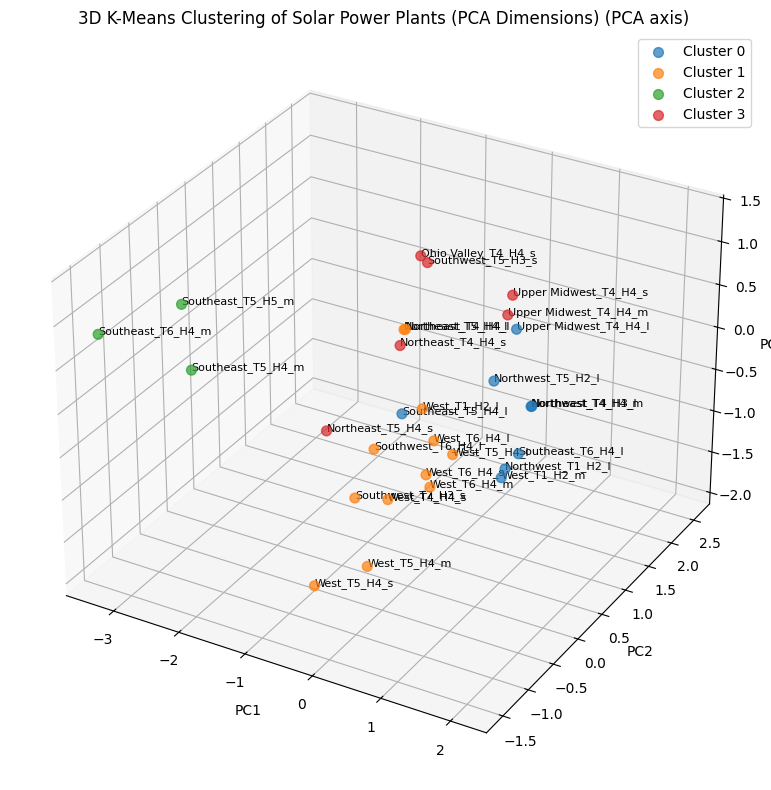

In [10]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA # Import PCA for clearer component naming
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df is already loaded here, as per your previous context:
# df = pd.read_csv("../Data/PV_data_clean.csv")
# df = df[df['randid'].isin(stations_to_keep)] # Assuming stations_to_keep is defined

df["solar_power_plant"] = df["NOAAClimRegion"] + "_" + df["TempZone"] + "_" + df["HumidZone"] + "_" + df["bin_PlantSize_kW"].apply(lambda x: x[0])

pca_features_start_col = "active_snow_tickets"
pca_features_end_col = "rain"
pca_feature_cols = df.columns[df.columns.get_loc(pca_features_start_col):df.columns.get_loc(pca_features_end_col)+1].tolist()

mapping_affected_assets = {"None": 0, "Partial": 1, "Full": 2}
mapping_production_level = {"N/A": 0, "Unknown": 0, "Partial": 1, "Full": 2}
mapping_wind_speed = {"Low": 0, "Medium": 1, "High": 2}

if "snow_affected_assets" in pca_feature_cols:
    df["snow_affected_assets"] = df["snow_affected_assets"].map(mapping_affected_assets)
if "snow_production_level" in pca_feature_cols:
    df["snow_production_level"] = df["snow_production_level"].map(mapping_production_level)
if "hurr_affected_assets" in pca_feature_cols:
    df["hurr_affected_assets"] = df["hurr_affected_assets"].map(mapping_affected_assets)
if "hurr_production_level" in pca_feature_cols:
    df["hurr_production_level"] = df["hurr_production_level"].map(mapping_production_level)
if "wind_speed_mean" in pca_feature_cols:
    df["wind_speed_mean"] = df["wind_speed_mean"].map(mapping_wind_speed)
if "storm_affected_assets" in pca_feature_cols:
    df["storm_affected_assets"] = df["storm_affected_assets"].map(mapping_affected_assets)
if "storm_production_level" in pca_feature_cols:
    df["storm_production_level"] = df["storm_production_level"].map(mapping_production_level)

# Filter pca_feature_cols to ensure only numerical columns are selected for aggregation
numeric_pca_feature_cols = df[pca_feature_cols].select_dtypes(include=np.number).columns.tolist()

df_grouped = df.groupby("solar_power_plant")[numeric_pca_feature_cols].mean().reset_index()

X = df_grouped[numeric_pca_feature_cols].values
X = np.nan_to_num(X, nan=0.0)

# Normalize the features to a range of -1 to +1
scaler = MinMaxScaler(feature_range=(-1, 1))
X_normalized = scaler.fit_transform(X)


# Perform PCA using sklearn.decomposition.PCA for easier handling of components
# It's good practice to explicitly use the PCA class, especially for outputting components
n_components_pca_output = 3 # You might want more than 3 if you need them for other purposes
pca = PCA(n_components=n_components_pca_output)
X_pca = pca.fit_transform(X_normalized) # This directly gives you the principal components

# Create a DataFrame for the PCA results
pca_columns = [f'PC{i+1}' for i in range(n_components_pca_output)]
df_pca_output = pd.DataFrame(data=X_pca, columns=pca_columns)

# Add the 'solar_power_plant' identifier back to the PCA DataFrame
df_pca_output['solar_power_plant'] = df_grouped['solar_power_plant']

# If you also need 'randid' directly associated with the PCA values,
# you'll need to reconsider how 'randid' relates to 'solar_power_plant'.
# 'randid' is a per-row identifier in the original df, while 'solar_power_plant'
# is a grouping key. If a 'solar_power_plant' can have multiple 'randid's,
# you might need to decide which 'randid' to associate, or output 'solar_power_plant' instead.

# Assuming 'solar_power_plant' is a unique identifier derived from 'randid'
# or that you're okay with 'solar_power_plant' as the primary identifier for PCA output.
# If 'randid' is truly what you need, and each 'solar_power_plant' corresponds
# to exactly one 'randid' (or you want one arbitrary 'randid' per plant),
# you'd need to bring it from the original df_grouped.
# Example: If you need ONE randid per solar_power_plant (e.g., the first one)
# df_grouped_with_randid = df.groupby("solar_power_plant").agg(
#     randid=('randid', 'first'), # Get the first randid for each group
#     **{col: ('mean' if col in numeric_pca_feature_cols else 'first') for col in numeric_pca_feature_cols} # Re-add other aggregations if needed
# ).reset_index()
# And then merge randid:
# df_pca_output = df_pca_output.merge(df_grouped_with_randid[['solar_power_plant', 'randid']], on='solar_power_plant', how='left')


# Reorder columns to have 'solar_power_plant' first
df_pca_output = df_pca_output[['solar_power_plant'] + pca_columns]

# Output to CSV
output_filename = "../Data/solar_plant_pca_values.csv"
df_pca_output.to_csv(output_filename, index=False)

# --- Rest of your K-Means and plotting code (using X_pca for plotting) ---

# Run K-Means clustering on all normalized features (X_normalized)
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_normalized) # K-Means uses normalized data directly

df_grouped["cluster"] = clusters # Add clusters to the grouped DataFrame
df_pca_output["cluster"] = clusters # Add clusters to the PCA output DataFrame if you want them there too

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

for cluster_id in range(n_clusters):
    cluster_data_pca = X_pca[clusters == cluster_id] # Use X_pca for plotting
    cluster_labels = df_grouped[df_grouped["cluster"] == cluster_id]["solar_power_plant"].tolist()

    ax.scatter(cluster_data_pca[:, 0], cluster_data_pca[:, 1], cluster_data_pca[:, 2],
               label=f'Cluster {cluster_id}', s=50, alpha=0.7)

    # Make sure cluster_data_pca has enough points for cluster_labels
    for i, txt in enumerate(cluster_labels):
        if i < len(cluster_data_pca): # Add this check for safety
            ax.text(cluster_data_pca[i, 0], cluster_data_pca[i, 1], cluster_data_pca[i, 2], txt, size=8, zorder=1, color='k')
        else:
            print(f"Warning: Not enough PCA points for label '{txt}' in Cluster {cluster_id}")


ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('3D K-Means Clustering of Solar Power Plants (PCA Dimensions) (PCA axis)')
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()

C:\Users\loolz\AppData\Local\Temp\ipykernel_19152\2410209121.py:122: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


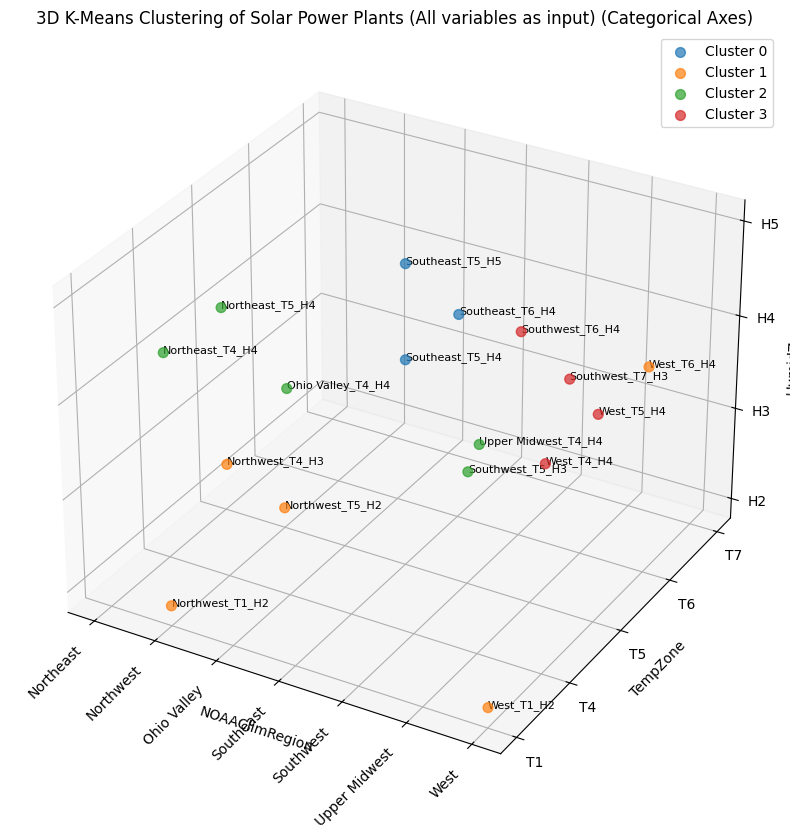

In [7]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder # Import LabelEncoder for robust categorical encoding

# df is expected to be loaded here before execution

df["solar_power_plant"] = df["NOAAClimRegion"] + "_" + df["TempZone"] + "_" + df["HumidZone"]

pca_features_start_col = "active_snow_tickets"
pca_features_end_col = "rain"
pca_feature_cols = df.columns[df.columns.get_loc(pca_features_start_col):df.columns.get_loc(pca_features_end_col)+1].tolist()

# Define mappings for categorical features within the PCA range
mapping_affected_assets = {"None": 0, "Partial": 1, "Full": 2}
mapping_production_level = {"N/A": 0, "Unknown": 0, "Partial": 1, "Full": 2}
mapping_wind_speed = {"Low": 0, "Medium": 1, "High": 2}

# Apply mappings
if "snow_affected_assets" in pca_feature_cols:
    df["snow_affected_assets"] = df["snow_affected_assets"].map(mapping_affected_assets)
if "snow_production_level" in pca_feature_cols:
    df["snow_production_level"] = df["snow_production_level"].map(mapping_production_level)
if "hurr_affected_assets" in pca_feature_cols:
    df["hurr_affected_assets"] = df["hurr_affected_assets"].map(mapping_affected_assets)
if "hurr_production_level" in pca_feature_cols:
    df["hurr_production_level"] = df["hurr_production_level"].map(mapping_production_level)
if "wind_speed_mean" in pca_feature_cols:
    df["wind_speed_mean"] = df["wind_speed_mean"].map(mapping_wind_speed)
if "storm_affected_assets" in pca_feature_cols:
    df["storm_affected_assets"] = df["storm_affected_assets"].map(mapping_affected_assets)
if "storm_production_level" in pca_feature_cols:
    df["storm_production_level"] = df["storm_production_level"].map(mapping_production_level)


# Filter pca_feature_cols to ensure only numerical columns are selected for aggregation
numeric_pca_feature_cols = df[pca_feature_cols].select_dtypes(include=np.number).columns.tolist()

df_grouped = df.groupby("solar_power_plant")[numeric_pca_feature_cols].mean().reset_index()

X = df_grouped[numeric_pca_feature_cols].values

X = np.nan_to_num(X, nan=0.0)

# Normalize the features to a range of -1 to +1
scaler = MinMaxScaler(feature_range=(-1, 1))
X_normalized = scaler.fit_transform(X)

# Run K-Means clustering on all normalized features (X_normalized)
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_normalized)

df_grouped["cluster"] = clusters

# Prepare categorical data for 3D plotting
# Split the 'solar_power_plant' string back into its components
df_grouped[['NOAAClimRegion', 'TempZone', 'HumidZone']] = df_grouped['solar_power_plant'].str.split('_', expand=True)

# Encode categorical axes numerically for plotting
le_region = LabelEncoder()
df_grouped['NOAAClimRegion_encoded'] = le_region.fit_transform(df_grouped['NOAAClimRegion'])

le_tempzone = LabelEncoder()
df_grouped['TempZone_encoded'] = le_tempzone.fit_transform(df_grouped['TempZone'])

le_humidzone = LabelEncoder()
df_grouped['HumidZone_encoded'] = le_humidzone.fit_transform(df_grouped['HumidZone'])


fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Get unique categories and their encoded values for axis ticks/labels
region_ticks = np.unique(df_grouped['NOAAClimRegion_encoded'])
region_labels = le_region.inverse_transform(region_ticks)

tempzone_ticks = np.unique(df_grouped['TempZone_encoded'])
tempzone_labels = le_tempzone.inverse_transform(tempzone_ticks)

humidzone_ticks = np.unique(df_grouped['HumidZone_encoded'])
humidzone_labels = le_humidzone.inverse_transform(humidzone_ticks)


# Plot each cluster
for cluster_id in range(n_clusters):
    cluster_data_plot = df_grouped[df_grouped["cluster"] == cluster_id]
    
    ax.scatter(cluster_data_plot['NOAAClimRegion_encoded'],
               cluster_data_plot['TempZone_encoded'],
               cluster_data_plot['HumidZone_encoded'],
               label=f'Cluster {cluster_id}', s=50, alpha=0.7)
    
    # Label each point
    for i, row in cluster_data_plot.iterrows():
        ax.text(row['NOAAClimRegion_encoded'],
                row['TempZone_encoded'],
                row['HumidZone_encoded'],
                row['solar_power_plant'],
                size=8, zorder=1, color='k')

ax.set_xlabel('NOAAClimRegion')
ax.set_ylabel('TempZone')
ax.set_zlabel('HumidZone')
ax.set_title('3D K-Means Clustering of Solar Power Plants (All variables as input) (Categorical Axes)')
ax.legend()
ax.grid(True)

# Set custom ticks and labels for categorical axes
ax.set_xticks(region_ticks)
ax.set_xticklabels(region_labels, rotation=45, ha='right')

ax.set_yticks(tempzone_ticks)
ax.set_yticklabels(tempzone_labels)

ax.set_zticks(humidzone_ticks)
ax.set_zticklabels(humidzone_labels)

plt.tight_layout()
plt.show()


C:\Users\loolz\AppData\Local\Temp\ipykernel_19152\377372055.py:137: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


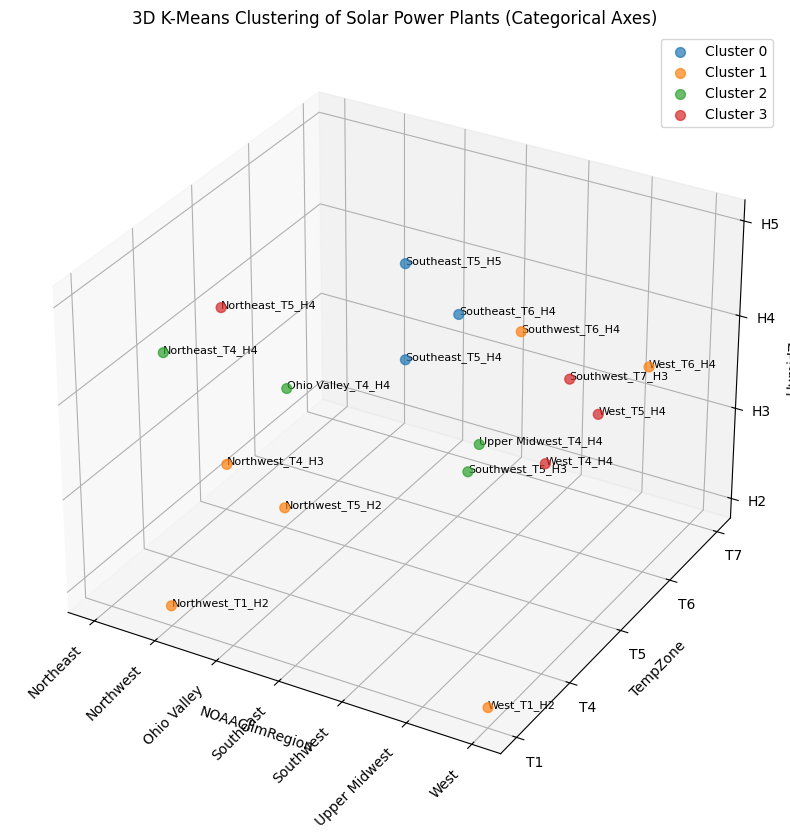

In [8]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder # Re-added LabelEncoder for categorical axis plotting

# df is expected to be loaded here before execution

df["solar_power_plant"] = df["NOAAClimRegion"] + "_" + df["TempZone"] + "_" + df["HumidZone"]

pca_features_start_col = "active_snow_tickets"
pca_features_end_col = "rain"
pca_feature_cols = df.columns[df.columns.get_loc(pca_features_start_col):df.columns.get_loc(pca_features_end_col)+1].tolist()

# Define mappings for categorical features within the PCA range
mapping_affected_assets = {"None": 0, "Partial": 1, "Full": 2}
mapping_production_level = {"N/A": 0, "Unknown": 0, "Partial": 1, "Full": 2}
mapping_wind_speed = {"Low": 0, "Medium": 1, "High": 2}

# Apply mappings
if "snow_affected_assets" in pca_feature_cols:
    df["snow_affected_assets"] = df["snow_affected_assets"].map(mapping_affected_assets)
if "snow_production_level" in pca_feature_cols:
    df["snow_production_level"] = df["snow_production_level"].map(mapping_production_level)
if "hurr_affected_assets" in pca_feature_cols:
    df["hurr_affected_assets"] = df["hurr_affected_assets"].map(mapping_affected_assets)
if "hurr_production_level" in pca_feature_cols:
    df["hurr_production_level"] = df["hurr_production_level"].map(mapping_production_level)
if "wind_speed_mean" in pca_feature_cols:
    df["wind_speed_mean"] = df["wind_speed_mean"].map(mapping_wind_speed)
if "storm_affected_assets" in pca_feature_cols:
    df["storm_affected_assets"] = df["storm_affected_assets"].map(mapping_affected_assets)
if "storm_production_level" in pca_feature_cols:
    df["storm_production_level"] = df["storm_production_level"].map(mapping_production_level)


# Filter pca_feature_cols to ensure only numerical columns are selected for aggregation
numeric_pca_feature_cols = df[pca_feature_cols].select_dtypes(include=np.number).columns.tolist()

df_grouped = df.groupby("solar_power_plant")[numeric_pca_feature_cols].mean().reset_index()

X = df_grouped[numeric_pca_feature_cols].values

X = np.nan_to_num(X, nan=0.0)

# Normalize the features to a range of -1 to +1
scaler = MinMaxScaler(feature_range=(-1, 1))
X_normalized = scaler.fit_transform(X)

# Perform PCA for dimensionality reduction (input for K-Means)
covariance_matrix = np.cov(X_normalized.T)

eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)

sorted_indices = np.argsort(eigenvalues)[::-1]
sorted_eigenvalues = eigenvalues[sorted_indices]
sorted_eigenvectors = eigenvectors[:, sorted_indices]

n_components = 3
principal_components = sorted_eigenvectors[:, :n_components]

X_pca_for_kmeans = X_normalized.dot(principal_components) # PCA for K-Means input

# Run K-Means clustering on the PCA-transformed data (X_pca_for_kmeans)
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_pca_for_kmeans) # K-Means uses PCA-transformed data

df_grouped["cluster"] = clusters

# Prepare categorical data for 3D plotting
# Split the 'solar_power_plant' string back into its components
df_grouped[['NOAAClimRegion', 'TempZone', 'HumidZone']] = df_grouped['solar_power_plant'].str.split('_', expand=True)

# Encode categorical axes numerically for plotting
le_region = LabelEncoder()
df_grouped['NOAAClimRegion_encoded'] = le_region.fit_transform(df_grouped['NOAAClimRegion'])

le_tempzone = LabelEncoder()
df_grouped['TempZone_encoded'] = le_tempzone.fit_transform(df_grouped['TempZone'])

le_humidzone = LabelEncoder()
df_grouped['HumidZone_encoded'] = le_humidzone.fit_transform(df_grouped['HumidZone'])


fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Get unique categories and their encoded values for axis ticks/labels
region_ticks = np.unique(df_grouped['NOAAClimRegion_encoded'])
region_labels = le_region.inverse_transform(region_ticks)

tempzone_ticks = np.unique(df_grouped['TempZone_encoded'])
tempzone_labels = le_tempzone.inverse_transform(tempzone_ticks)

humidzone_ticks = np.unique(df_grouped['HumidZone_encoded'])
humidzone_labels = le_humidzone.inverse_transform(humidzone_ticks)


# Plot each cluster using the encoded categorical axes
for cluster_id in range(n_clusters):
    cluster_data_plot = df_grouped[df_grouped["cluster"] == cluster_id]
    
    ax.scatter(cluster_data_plot['NOAAClimRegion_encoded'],
               cluster_data_plot['TempZone_encoded'],
               cluster_data_plot['HumidZone_encoded'],
               label=f'Cluster {cluster_id}', s=50, alpha=0.7)
    
    # Label each point
    for i, row in cluster_data_plot.iterrows():
        ax.text(row['NOAAClimRegion_encoded'],
                row['TempZone_encoded'],
                row['HumidZone_encoded'],
                row['solar_power_plant'],
                size=8, zorder=1, color='k')

# Set axes labels for categorical variables
ax.set_xlabel('NOAAClimRegion')
ax.set_ylabel('TempZone')
ax.set_zlabel('HumidZone')
ax.set_title('3D K-Means Clustering of Solar Power Plants (Categorical Axes)')
ax.legend()
ax.grid(True)

# Set custom ticks and labels for categorical axes
ax.set_xticks(region_ticks)
ax.set_xticklabels(region_labels, rotation=45, ha='right')

ax.set_yticks(tempzone_ticks)
ax.set_yticklabels(tempzone_labels)

ax.set_zticks(humidzone_ticks)
ax.set_zticklabels(humidzone_labels)

plt.tight_layout()
plt.show()
